In [185]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
import itertools
import sys

sys.path.append("..")

from utility_functions import (calculate_model_performance,
                               plot_ROC,
                               one_hot_encode,
                               split_data_as,
                               grid_search,
                               shuffled,
                               timeit)

EPSILON = 10e-08


def get_shapes(any_):
    for array in any_:
        try:
            print(array.shape)
        except:
            print("NONE")
    print("\n")


# ============= ACTIVATION FUNCTIONS ===============#

def sigmoid(Z, prime=False):
    # np.
    if prime:
        return sigmoid(Z) * (1 - sigmoid(Z))
    return 1 / (1 + np.exp(-Z))


def linear(Z, prime=False):
    if prime:
        return np.ones_like(Z)
    return Z


def relu(Z, alpha=0.01, prime=False):
    if prime:
        Z_relu = np.ones_like(Z, dtype=np.float64)
        Z_relu[Z < 0] = alpha
        return Z_relu
    return np.where(Z < 0, alpha * Z, Z)


def tanh(Z, prime=False):
    # np.tanh() could be used directly to speed this up
    if prime:
        return 1 - np.power(tanh(Z), 2)
    return (2 / (1 + np.exp(-2 * Z))) - 1


def elu(Z, prime=False):
    # https://mlfromscratch.com/activation-functions-explained/#/
    alpha = 0.2
    if prime:
        return np.where(Z < 0, alpha * (np.exp(Z)), 1)
    return np.where(Z < 0, alpha * (np.exp(Z) - 1), Z)


def softmax(Z, prime=False):
    # https://deepnotes.io/softmax-crossentropy
    # max(Z) term is added to stabilise the function.
    exps = np.exp(Z - np.max(Z))
    return exps / np.sum(exps, axis=0)


# References
# https://mc.ai/multilayered-neural-network-from-scratch-using-python/
# https://mattmazur.com/2015/03/17/a-step-by-step-backpropagation-example/
# https://www.coursera.org/learn/machine-learning/home/week/5
# https://www.coursera.org/specializations/deep-learning
# https://github.com/mnielsen/neural-networks-and-deep-learning/blob/master/src/network.py
# https://github.com/JWarmenhoven/Coursera-Machine-Learning

class NeuralNetwork:

    def __init__(
            self,
            input_layer: tuple,
            hidden_layer: list,  # list of tuples
            output_layer: int,
            batch_size=16,
            alpha=0.01,
            optimizer="SGD",
            penalty="l2",
            lambd=0.01,
            keep_prob = None,
            epoch=500,
            random_state=42,
            verbose=True,
            metrics="accuracy"
    ):
        self.input_layer = input_layer
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.mini_batch_size = batch_size
        self.alpha = alpha
        self.optimizer = optimizer
        self.penalty = penalty
        self.lambd = lambd
        self.keep_prob = keep_prob
        # dropout: http://jmlr.org/papers/volume15/srivastava14a.old/srivastava14a.pdf
        self.dropout = True if isinstance(self.keep_prob, float) else False
        self.epoch = epoch
        self.seed = random_state
        self.verbose = verbose
        self.metrics = metrics
        self.layers = len(self.weight_set_dimensions) + 1
        self.EPSILON = 10e-10


    def __str__(self):
        parameters = (
            "Input layer: {0}\n"
            "Hidden layer: {1}\n"
            "Output layer: {2}\n"
            "Batch size: {3}\n"
            "Learning rate: {4}\n"
            "Epoch: {5}\n"
            "Seed: {6}\n"
            "Verbose: {7}\n"
            "Metric: {8}"
        ).format(
            self.input_layer,
            " - ".join(map(str, self.hidden_layer)),
            self.output_layer,
            self.mini_batch_size,
            self.alpha,
            self.epoch,
            self.seed,
            self.verbose,
            self.metrics
        )
        return parameters

    def get_A(self, X, predict=True):
        A, _ = self.forwardpass(X, predict=predict)
        return A

    def get_Z(self, X, predict=True):
        _, Z = self.forwardpass(X, predict=predict)
        return Z
    
    # ============== LOSS FUNCTIONS ===============#

    # https://deepnotes.io/softmax-crossentropy

    def calculate_error(self, Y, Y_hat):
        # Y and Y_hat should be in the form of (no_of_classes, no_of_training_examples)
        cost = -np.sum(Y * np.log(Y_hat + EPSILON)) / self.m
        if self.penalty == "l1":
            for layer in range(1, self.layers):
                cost += np.sum(np.abs(self.W[layer])) * self.lambd / (2 * self.m)
        elif self.penalty == "l2":
            for layer in range(1, self.layers):
                cost += np.sum(np.square(self.W[layer])) * self.lambd / (2 * self.m)
        return cost


    def display_information(self, X, Y, epoch_no):
        model_performance_metrics = calculate_model_performance(
            np.argmax(Y, axis=0),
            self.predict(X)
        )
        print("%s: %.10f - epoch %s    iteration %s - loss %.20f" % (
            self.metrics,
            model_performance_metrics[self.metrics],
            epoch_no,
            self.no_of_iterations,
            self.calculate_error(Y,
                            self.get_A(X)[-1])
        ))

    def get_dimensions_and_activations(self):
        self.dimensions = []
        self.activation_functions = []

        self.dimensions.append(self.input_layer[0])
        self.activation_functions.append(self.input_layer[1])

        for dim, act_func in self.hidden_layer:
            self.dimensions.append(dim)
            self.activation_functions.append(act_func)

        self.dimensions.append(self.output_layer)

    @property
    def weight_set_dimensions(self):
        self.get_dimensions_and_activations()
        a, b = itertools.tee(self.dimensions[::-1])
        next(b, None)
        weight_set_dimensions = list(zip(a, b))[::-1]
        return weight_set_dimensions

    def initialise_weights(self, layer=None):
        self.W = np.empty_like(range(self.layers), dtype=object)
        self.B = np.empty_like(range(self.layers), dtype=object)
        for layer, (y, x) in zip(range(1, self.layers), self.weight_set_dimensions):
            np.random.seed(self.seed)
            self.W[layer] = np.random.rand(y, x) / np.sqrt(self.dimensions[layer - 1])
            self.B[layer] = np.random.rand(y, 1)

    def forwardpass(self, X, predict=False):
        Z = np.empty_like(range(self.layers), dtype=object)
        A = np.empty_like(range(self.layers), dtype=object)
        A[0] = X

        for layer in range(1, self.layers):
            # activation_function starts from 0 whereas layer starts from 1
            active_function = self.activation_functions[layer - 1]
            arg_to_pass_to_eval = "(Z[layer])"

            Z[layer] = self.W[layer] @ A[layer - 1] + self.B[layer]
            A[layer] = eval(active_function + arg_to_pass_to_eval)
            
            # dropout is only applied to first hidden layer
            # https://www.kaggle.com/mtax687/dropout-regularization-of-neural-net-using-numpy
            if self.dropout and layer == 1 and not predict:
                self.D = np.random.randn(A[layer].shape[0], A[layer].shape[1])
                self.D = (self.D < self.keep_prob)
                A[layer] = np.multiply(A[layer], self.D) / self.keep_prob

        return A, Z

    def backpropagation(self, Y, A, Z):
        self.delta = np.empty_like(range(self.layers), dtype=object)

        self.gradient_W = np.empty_like(range(self.layers), dtype=object)
        self.gradient_B = np.empty_like(range(self.layers), dtype=object)

        self.delta[-1] = A[-1] - Y

        # We substract 1 here as delta_final is calculated seperately above
        for layer in reversed(range(1, self.layers - 1)):
            # 1 is substracted from layer as activation_functions start indexing from 0
            active_function = self.activation_functions[layer - 1]
            arg_to_pass_to_eval = "(Z[layer], prime=True)"
            
            DA = self.W[layer + 1].T @ self.delta[layer + 1]

            # If dropout is applied
            if self.dropout and layer == 1:
                DA = np.multiply(DA, self.D) / self.keep_prob


            self.delta[layer] = (
                    DA *
                    eval(active_function + arg_to_pass_to_eval)
            )

        for layer in range(1, self.layers):
            self.gradient_W[layer] = (self.delta[layer] @ A[layer - 1].T) / self.m
            self.gradient_B[layer] = np.sum(self.delta[layer], axis=1, keepdims=True) / self.m
            
            if self.penalty == "l1":
                # https://towardsdatascience.com/only-numpy-implementing-different-combination-of-l1-norm-l2-norm-l1-regularization-and-14b01a9773b
                self.gradient_W[layer] += np.where(self.W[layer] < 0, -1, 1) * (self.lambd / self.m)
            elif self.penalty == "l2":
                self.gradient_W[layer] += self.W[layer] * (self.lambd / self.m)
            
        self.update_weights()

    def update_weights(self):
        if self.optimizer == "SGD":
            for layer in range(1, self.layers):
                self.W[layer] -= self.alpha * self.gradient_W[layer]
                self.B[layer] -= self.alpha * self.gradient_B[layer]

        elif self.optimizer["method"] == "SGDM":
            for layer in range(1, self.layers):
                beta = self.optimizer["beta"]
                self.v_dw[layer] = beta * self.v_dw[layer] + (1 - beta) * self.gradient_W[layer]
                self.v_db[layer] = beta * self.v_db[layer] + (1 - beta) * self.gradient_B[layer]

                self.W[layer] -= self.alpha * self.v_dw[layer]
                self.B[layer] -= self.alpha * self.v_db[layer]

        elif self.optimizer["method"] == "RMSP":
            for layer in range(1, self.layers):
                beta = self.optimizer["beta"]
                self.s_dw[layer] = beta * self.s_dw[layer] + (1 - beta) * np.square(self.gradient_W[layer])
                self.s_db[layer] = beta * self.s_db[layer] + (1 - beta) * np.square(self.gradient_B[layer])

                w_rms_grad = self.gradient_W[layer] / (np.sqrt(self.s_dw[layer]) + self.EPSILON)
                b_rms_grad = self.gradient_B[layer] / (np.sqrt(self.s_db[layer]) + self.EPSILON)

                self.W[layer] -= self.alpha * w_rms_grad
                self.B[layer] -= self.alpha * b_rms_grad

        elif self.optimizer["method"] == "ADAM":
            # EWA: Exponential weighted average
            # ToDo: Check if bias correction is necessary. The EWA will be inaccurate initially,
            # but it shouldn't take many iterations to compute correct EWA.
            for layer in range(1, self.layers):
                beta1 = self.optimizer["beta1"]
                beta2 = self.optimizer["beta2"]
                self.v_dw[layer] = beta1 * self.v_dw[layer] + (1 - beta1) * self.gradient_W[layer]
                self.v_db[layer] = beta1 * self.v_db[layer] + (1 - beta1) * self.gradient_B[layer]

                self.s_dw[layer] = beta2 * self.s_dw[layer] + (1 - beta2) * np.square(self.gradient_W[layer])
                self.s_db[layer] = beta2 * self.s_db[layer] + (1 - beta2) * np.square(self.gradient_B[layer])

                v_dw_corrected = self.v_dw[layer] / (1 - beta1 ** self.no_of_iterations)
                s_dw_corrected = self.s_dw[layer] / (1 - beta2 ** self.no_of_iterations)

                v_db_corrected = self.v_db[layer] / (1 - beta1 ** self.no_of_iterations)
                s_db_corrected = self.s_db[layer] / (1 - beta2 ** self.no_of_iterations)

                self.W[layer] -= self.alpha * (v_dw_corrected / (np.sqrt(s_dw_corrected) + self.EPSILON))
                self.B[layer] -= self.alpha * (v_db_corrected / (np.sqrt(s_db_corrected) + self.EPSILON))


    def initialise_cache(self):
        self.v_dw = np.empty_like(range(self.layers), dtype=object)
        self.v_db = np.empty_like(range(self.layers), dtype=object)
    
        self.s_dw = np.empty_like(range(self.layers), dtype=object)
        self.s_db = np.empty_like(range(self.layers), dtype=object)

        for layer, (y, x) in zip(range(1, self.layers), self.weight_set_dimensions):
            self.v_dw[layer] = np.zeros((y, x))
            self.v_db[layer] = np.zeros((y, 1))
            
            self.s_dw[layer] = np.zeros((y, x))
            self.s_db[layer] = np.zeros((y, 1))

    @timeit
    def fit(self, X, Y):
        self.m = X.shape[1] # where (no_of_features, no_of_training_examples)
        self.initialise_weights()
        self.initialise_cache()

        # By default the method is SGD(Stochastic Gradient Descent) if one wishes to use
        # the whole batch, simply pass the number of traning examples available as the
        # batch size when instantiating the class
        self.no_of_iterations = 0
        shuffled = np.arange(self.m)
        if self.verbose:
            print("Initialising weights...")
            print("Starting the training...")
            print("Initial cost: %.10f\n" % self.calculate_error(Y, self.get_A(X)[-1]))
        for epoch_no in range(1, self.epoch + 1):
            np.random.shuffle(shuffled)
            X_shuffled = X[:, shuffled]
            Y_shuffled = Y[:, shuffled]
            for i in range(0, self.m, self.mini_batch_size):
                self.no_of_iterations += 1
                X_mini_batch = X_shuffled[:, i: i + self.mini_batch_size]
                Y_mini_batch = Y_shuffled[:, i: i + self.mini_batch_size]

                A, Z = self.forwardpass(X_mini_batch)
                self.backpropagation(Y_mini_batch, A, Z)
                if self.no_of_iterations % 100 == 0 and self.verbose:
                    self.display_information(X, Y, epoch_no)

    def predict(
            self,
            X: np.ndarray,
            apply_dropout=False,
            return_prob_matrix=False,
    ):
        """Predict the output given the training data.

            Returns the predicted values in two forms:

            1.either by picking up the highest value along the columns for every row,
                i.e. "np.argmax(self.A[-1].T, axis=1)"
            2.or by returning a matrix that is in the shape of Y.T where each column
                represents the probability of the instance belonging to that class.
                Please note that every column in Y.T represents a class. To be able to
                return the probability matrix, the final activation function must be
                softmax!
                i.e. "array([0.9650488423, 0.0354737543, 0.0005225966])"

        Args:
            X (numpy.ndarray): Training set in the shape of
                (no_of_features, no_of_training examples).
            return_prob_matrix (bool, optional): Returns the probability matrix if True.
                Defaults to False.

        Returns:
            numpy.ndarray:

            if return_prob_matrix is False, the output is in the shape of
                (no_of_training_examples, 1)
            if return_prob_matrix is True, the output is in the shape of
                (no_of_training_examples, no_of_features)
        """
        # here predict means if forwardpass is called from predict method
        # if so, there is an option to apply or not apply dropout
        predict = np.invert(apply_dropout)
        A, Z = self.forwardpass(X, predict=predict)
        if return_prob_matrix:
            np.set_printoptions(precision=10, suppress=True)
            return A[-1].T
        return np.argmax(A[-1].T, axis=1)

In [ ]:
np.random.normal(
    0,
    np.sqrt(
        2.0/layer_dims[l-1]
    ),
    (layer_dims[l], layer_dims[l-1])
)

In [154]:
from sklearn.datasets import load_iris
data = load_iris()

x = data.data[:,[0,2]]
y = data.target

X = x.T
Y = one_hot_encode(y).T

In [155]:
from keras.models import Sequential
from keras.layers import Dense
from keras import optimizers
from keras import initializers
from keras.layers import Dropout
import time

In [110]:
start = time.time()
model_keras = Sequential()
model_keras.add(Dense(4, input_dim=2, activation='relu'))
model_keras.add(Dropout(0.5))
model_keras.add(Dense(4, activation='relu'))
model_keras.add(Dense(3, activation='softmax'))
adam = optimizers.Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999, amsgrad=False)
model_keras.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
model_keras.fit(X.T,Y.T, batch_size=10, epochs=100)
end = time.time()
print(end - start)

Epoch 1/100
150/150 [==============================] - 0s 500us/step - loss: 2.0817 - accuracy: 0.2400
Epoch 2/100
150/150 [==============================] - 0s 83us/step - loss: 1.2193 - accuracy: 0.2933
Epoch 3/100
150/150 [==============================] - 0s 81us/step - loss: 1.1681 - accuracy: 0.2867
Epoch 4/100
150/150 [==============================] - 0s 93us/step - loss: 1.1259 - accuracy: 0.2000
Epoch 5/100
150/150 [==============================] - 0s 76us/step - loss: 1.1291 - accuracy: 0.2600
Epoch 6/100
150/150 [==============================] - 0s 96us/step - loss: 1.1041 - accuracy: 0.2733
Epoch 7/100
150/150 [==============================] - 0s 88us/step - loss: 1.1018 - accuracy: 0.2733
Epoch 8/100
150/150 [==============================] - 0s 69us/step - loss: 1.0939 - accuracy: 0.2667
Epoch 9/100
150/150 [==============================] - 0s 88us/step - loss: 1.1049 - accuracy: 0.3067
Epoch 10/100
150/150 [==============================] - 0s 87us/step - loss: 1.09

150/150 [==============================] - 0s 75us/step - loss: 0.5827 - accuracy: 0.7733
Epoch 81/100
150/150 [==============================] - 0s 87us/step - loss: 0.6156 - accuracy: 0.7667
Epoch 82/100
150/150 [==============================] - 0s 93us/step - loss: 0.6657 - accuracy: 0.7000
Epoch 83/100
150/150 [==============================] - 0s 85us/step - loss: 0.5966 - accuracy: 0.7733
Epoch 84/100
150/150 [==============================] - 0s 87us/step - loss: 0.6370 - accuracy: 0.7467
Epoch 85/100
150/150 [==============================] - 0s 73us/step - loss: 0.6011 - accuracy: 0.7600
Epoch 86/100
150/150 [==============================] - 0s 79us/step - loss: 0.5759 - accuracy: 0.7533
Epoch 87/100
150/150 [==============================] - 0s 73us/step - loss: 0.6067 - accuracy: 0.7333
Epoch 88/100
150/150 [==============================] - 0s 84us/step - loss: 0.6246 - accuracy: 0.7200
Epoch 89/100
150/150 [==============================] - 0s 75us/step - loss: 0.5492 - 

# Testing with benchmark datasets

## 1.Iris Dataset

In [186]:
from sklearn.datasets import load_iris
data = load_iris()

x = data.data[:,[0,2]]
y = data.target

X = x.T
Y = one_hot_encode(y).T

In [187]:
print(X.shape)
print(Y.shape)

(2, 150)
(3, 150)


In [190]:
model = NeuralNetwork(
    input_layer=(2, 'relu'),
    hidden_layer=[(4,'relu'),(4,'softmax')],
    output_layer=3,
    batch_size=10,
    optimizer={"method": "ADAM", "beta1": 0.9, "beta2": 0.999},
    keep_prob=0.9,
    penalty=None,
    epoch=100,
    alpha=0.01
)

model.fit(X,Y)

Initialising weights...
Starting the training...
Initial cost: 8.7035852998

accuracy: 66.6666666662 - epoch 7    iteration 100 - loss 0.81679044157560820594
accuracy: 74.6666666662 - epoch 14    iteration 200 - loss 0.55290031497347713607
accuracy: 72.6666666662 - epoch 20    iteration 300 - loss 0.45284215744647488000
accuracy: 83.3333333328 - epoch 27    iteration 400 - loss 0.39346929757401072347
accuracy: 74.6666666662 - epoch 34    iteration 500 - loss 0.38768273973825351231
accuracy: 89.3333333327 - epoch 40    iteration 600 - loss 0.32544360307664721432
accuracy: 92.6666666660 - epoch 47    iteration 700 - loss 0.29742743357154133310
accuracy: 95.9999999994 - epoch 54    iteration 800 - loss 0.26910790209514162674
accuracy: 96.6666666660 - epoch 60    iteration 900 - loss 0.24809579300344386521
accuracy: 94.6666666660 - epoch 67    iteration 1000 - loss 0.22300679938611017716
accuracy: 93.9999999994 - epoch 74    iteration 1100 - loss 0.20901666769143245617
accuracy: 95.9999999

In [189]:
calculate_model_performance(np.argmax(Y, axis=0),
                           model.predict(X))

{'specificity': 99.999999999,
 'accuracy': 95.99999999936001,
 'prevalence': 33.33333333311111,
 'precision': 99.99999999772729,
 'sensitivity/recall': 87.99999999824001,
 'F1': 93.61702127410595,
 'false_positive_rate': 0.0}

In [160]:
# results_dict_all_models, results_average_dict, models = grid_search(
#     x,
#     y,
#     clf=NeuralNetwork,
#     lst_metrics=["F1", "accuracy"],
#     sort_by = "accuracy",
#     n_folds=5,
#     dict_param_grid={
#         'batch_size': [8, 16, 32],
#         'input_layer': [(2, 'relu')],
#         'hidden_layer': [
#             [(4,'relu'), (4,'softmax')],
#             [(4,'sigmoid'),(4,'softmax')]
#         ],
#         'optimizer': [
#             {
#                 "method": "RMSP",
#                 "beta": 0.9
#             }
#         ],
#         'output_layer': [3],
#         'alpha': [0.001],
#         'verbose': [False],
#         'epoch': [1000]
#     }
# )

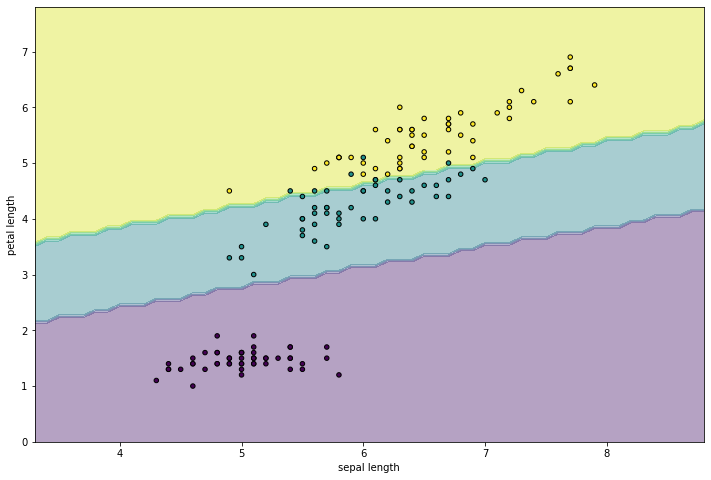

In [161]:
# %matplotlib inline
import matplotlib.pyplot as plt
dt = data.data[:,[0,2]]
x_min, x_max = dt[:, 0].min() - 1, dt[:, 0].max() + 1
y_min, y_max = dt[:, 1].min() - 1, dt[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T, apply_dropout=False)

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')

plt.scatter(dt[:, 0], dt[:, 1], c=y,s=20, edgecolor='k')
plt.xlabel('sepal length')
plt.ylabel('petal length')
plt.show()

## 2.Make Moons dataset

In [48]:
from sklearn.datasets import make_moons

x,y =make_moons(n_samples=1500, noise=.05)
X = x.T
Y = one_hot_encode(y).T

print(X.shape)
print(Y.shape)

(2, 1500)
(2, 1500)


In [49]:
model = NeuralNetwork(
    input_layer=(X.shape[0], 'relu'),
    hidden_layer=[(10,'relu'), (4,'softmax')],
    output_layer=Y.shape[0],
    batch_size=8,
    optimizer=
    {
        "method": "ADAM",
        "beta1": 0.9,
        "beta2": 0.999
    },
    penalty = "l2",
    keep_prob=0.5,
    lambd=0.001,
    epoch=250,
    alpha=0.01
)

model.fit(X,Y)

Initialising weights...
Starting the training...
Initial cost: 0.7260153660

accuracy: 87.6666666666 - epoch 1    iteration 100 - loss 0.28384687044411749390
accuracy: 88.5333333333 - epoch 2    iteration 200 - loss 0.26626153263735019561
accuracy: 88.3999999999 - epoch 2    iteration 300 - loss 0.28185148396788334280
accuracy: 88.5333333333 - epoch 3    iteration 400 - loss 0.27270110498298116841
accuracy: 88.3333333333 - epoch 3    iteration 500 - loss 0.27638922153339517962
accuracy: 88.2666666666 - epoch 4    iteration 600 - loss 0.25518347578273326004
accuracy: 88.4666666666 - epoch 4    iteration 700 - loss 0.25342273136255422106
accuracy: 88.6666666666 - epoch 5    iteration 800 - loss 0.24411695210017911317
accuracy: 88.6666666666 - epoch 5    iteration 900 - loss 0.23722881993780503551
accuracy: 88.0666666666 - epoch 6    iteration 1000 - loss 0.24226657187113145864
accuracy: 91.0666666666 - epoch 6    iteration 1100 - loss 0.22095541670144319690
accuracy: 87.9999999999 - epoc

accuracy: 97.9333333333 - epoch 54    iteration 10100 - loss 0.07194952793213706121
accuracy: 98.2666666666 - epoch 55    iteration 10200 - loss 0.07542615533692109686
accuracy: 94.8666666666 - epoch 55    iteration 10300 - loss 0.14302668749659375180
accuracy: 99.2666666666 - epoch 56    iteration 10400 - loss 0.09123043209664287445
accuracy: 99.4666666666 - epoch 56    iteration 10500 - loss 0.07500316009002000461
accuracy: 99.6666666666 - epoch 57    iteration 10600 - loss 0.06441772089487635133
accuracy: 96.4666666666 - epoch 57    iteration 10700 - loss 0.09896860850620098349
accuracy: 98.3333333333 - epoch 58    iteration 10800 - loss 0.07454831461336325349
accuracy: 90.4666666666 - epoch 58    iteration 10900 - loss 0.16384219271905403614
accuracy: 98.3999999999 - epoch 59    iteration 11000 - loss 0.08425532291680451480
accuracy: 99.3999999999 - epoch 60    iteration 11100 - loss 0.06638893568385043076
accuracy: 94.6666666666 - epoch 60    iteration 11200 - loss 0.1164188555644

accuracy: 99.9999999999 - epoch 109    iteration 20400 - loss 0.02258014076266638692
accuracy: 99.8666666666 - epoch 110    iteration 20500 - loss 0.03190695972214323967
accuracy: 99.8666666666 - epoch 110    iteration 20600 - loss 0.02991527992908472530
accuracy: 99.9999999999 - epoch 111    iteration 20700 - loss 0.02333504587802421454
accuracy: 99.8666666666 - epoch 111    iteration 20800 - loss 0.02906435559094947690
accuracy: 98.9333333333 - epoch 112    iteration 20900 - loss 0.06874929725204932673
accuracy: 99.9333333333 - epoch 112    iteration 21000 - loss 0.02803363720174585280
accuracy: 95.0666666666 - epoch 113    iteration 21100 - loss 0.09539113959372107210
accuracy: 99.9999999999 - epoch 113    iteration 21200 - loss 0.01269718819796875758
accuracy: 99.7999999999 - epoch 114    iteration 21300 - loss 0.05242829744057843355
accuracy: 99.8666666666 - epoch 114    iteration 21400 - loss 0.03118713824779715746
accuracy: 99.8666666666 - epoch 115    iteration 21500 - loss 0.0

accuracy: 99.9999999999 - epoch 161    iteration 30200 - loss 0.01383561931225858049
accuracy: 99.9999999999 - epoch 162    iteration 30300 - loss 0.02661091578424383194
accuracy: 99.9999999999 - epoch 162    iteration 30400 - loss 0.04146493962209849005
accuracy: 99.9333333333 - epoch 163    iteration 30500 - loss 0.02559473619336619446
accuracy: 99.4666666666 - epoch 163    iteration 30600 - loss 0.05894464554448612670
accuracy: 97.9999999999 - epoch 164    iteration 30700 - loss 0.05499611133749751635
accuracy: 99.9999999999 - epoch 164    iteration 30800 - loss 0.02606407298292016256
accuracy: 99.9999999999 - epoch 165    iteration 30900 - loss 0.03762558918921495715
accuracy: 99.9333333333 - epoch 165    iteration 31000 - loss 0.03156490968484415571
accuracy: 99.9999999999 - epoch 166    iteration 31100 - loss 0.02022349654723617357
accuracy: 99.9333333333 - epoch 166    iteration 31200 - loss 0.02470420547782285411
accuracy: 99.8666666666 - epoch 167    iteration 31300 - loss 0.0

accuracy: 99.8666666666 - epoch 213    iteration 40000 - loss 0.03227147842658589089
accuracy: 99.9999999999 - epoch 214    iteration 40100 - loss 0.02926995833975980232
accuracy: 99.8666666666 - epoch 214    iteration 40200 - loss 0.04109778608184450066
accuracy: 99.9333333333 - epoch 215    iteration 40300 - loss 0.01544643521189079625
accuracy: 99.7999999999 - epoch 215    iteration 40400 - loss 0.01837978539873247677
accuracy: 99.8666666666 - epoch 216    iteration 40500 - loss 0.01807232336979104972
accuracy: 99.7333333333 - epoch 216    iteration 40600 - loss 0.03174148313969354235
accuracy: 97.1333333333 - epoch 217    iteration 40700 - loss 0.06295074740623592124
accuracy: 99.9333333333 - epoch 218    iteration 40800 - loss 0.01774533083452527193
accuracy: 99.9999999999 - epoch 218    iteration 40900 - loss 0.02413919150547817055
accuracy: 99.8666666666 - epoch 219    iteration 41000 - loss 0.04195463133534407113
accuracy: 99.3333333333 - epoch 219    iteration 41100 - loss 0.0

Text(0.5, 1.0, 'Decision Boundaries')

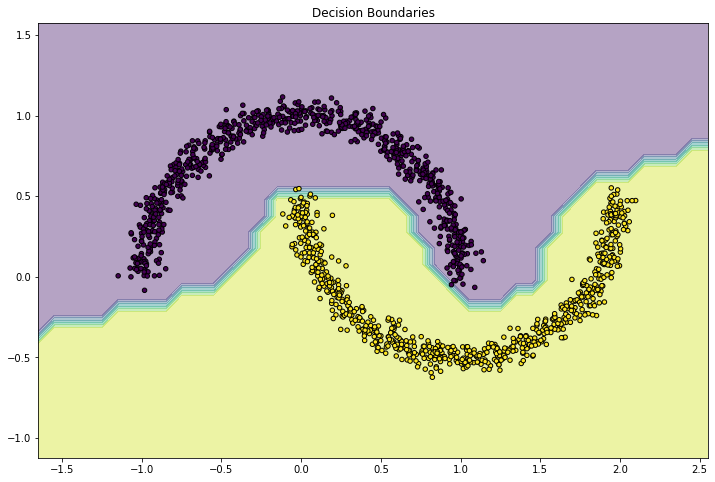

In [53]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
dt = x
x_min, x_max = dt[:, 0].min() - 0.5, dt[:, 0].max() + 0.5
y_min, y_max = dt[:, 1].min() - 0.5, dt[:, 1].max() + 0.5
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx.ravel(), yy.ravel()].T, apply_dropout=False) 

# Put the result into a color plot
Z = Z.reshape(xx.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx, yy, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(dt[:, 0], dt[:, 1], c=y, s=20, edgecolor='k')
plt.title('Decision Boundaries')

## 3.Andrew NG Assignment 2 Dataset

In [162]:
ex2data2 = np.loadtxt("../ex2/data/ex2data2.txt", delimiter=",")

x = ex2data2[:, :-1]
y = ex2data2[:, -1]

X = x.T
Y = one_hot_encode(y).T

In [163]:
print(X.shape)
print(Y.shape)

(2, 118)
(2, 118)


In [164]:
model = NeuralNetwork(
    input_layer=(X.shape[0], 'relu'),
    hidden_layer=[(8,'relu'), (4,'softmax')],
    output_layer=Y.shape[0],
    batch_size=8,
    optimizer={"method": "ADAM", "beta1": 0.9, "beta2": 0.999},
    keep_prob=0.8,
    epoch=1500,
    alpha=0.01
)

model.fit(X,Y)

Initialising weights...
Starting the training...
Initial cost: 4.4895649639

accuracy: 50.8474576267 - epoch 7    iteration 100 - loss 0.69823698899148267660
accuracy: 59.3220338978 - epoch 14    iteration 200 - loss 0.67910041165333978608
accuracy: 56.7796610165 - epoch 20    iteration 300 - loss 0.66531872555067428365
accuracy: 61.0169491520 - epoch 27    iteration 400 - loss 0.64705046952560218987
accuracy: 61.0169491520 - epoch 34    iteration 500 - loss 0.63435774667732103271
accuracy: 70.3389830503 - epoch 40    iteration 600 - loss 0.61556131501899624681
accuracy: 72.0338983045 - epoch 47    iteration 700 - loss 0.59636300748291326546
accuracy: 64.4067796605 - epoch 54    iteration 800 - loss 0.60801265100839252398
accuracy: 74.5762711858 - epoch 60    iteration 900 - loss 0.54479919810765686794
accuracy: 72.8813559316 - epoch 67    iteration 1000 - loss 0.52877498390389032767
accuracy: 80.5084745756 - epoch 74    iteration 1100 - loss 0.48744571259857000234
accuracy: 81.3559322

accuracy: 85.5932203383 - epoch 680    iteration 10200 - loss 0.37210022960744676412
accuracy: 84.7457627111 - epoch 687    iteration 10300 - loss 0.36626507366201804805
accuracy: 87.2881355925 - epoch 694    iteration 10400 - loss 0.36104428298505186756
accuracy: 83.8983050840 - epoch 700    iteration 10500 - loss 0.37775327754977644501
accuracy: 85.5932203383 - epoch 707    iteration 10600 - loss 0.36461980064685661773
accuracy: 85.5932203383 - epoch 714    iteration 10700 - loss 0.37196856559457930347
accuracy: 84.7457627111 - epoch 720    iteration 10800 - loss 0.36334750528665477054
accuracy: 83.0508474569 - epoch 727    iteration 10900 - loss 0.37971389875716082818
accuracy: 85.5932203383 - epoch 734    iteration 11000 - loss 0.35070153999968922687
accuracy: 85.5932203383 - epoch 740    iteration 11100 - loss 0.36520283307111167659
accuracy: 84.7457627111 - epoch 747    iteration 11200 - loss 0.35558074909206321967
accuracy: 84.7457627111 - epoch 754    iteration 11300 - loss 0.3

accuracy: 84.7457627111 - epoch 1320    iteration 19800 - loss 0.34690509199581986977
accuracy: 85.5932203383 - epoch 1327    iteration 19900 - loss 0.35294866291703252958
accuracy: 84.7457627111 - epoch 1334    iteration 20000 - loss 0.36266973774538230346
accuracy: 86.4406779654 - epoch 1340    iteration 20100 - loss 0.35934492369301362924
accuracy: 84.7457627111 - epoch 1347    iteration 20200 - loss 0.36132667202545964980
accuracy: 86.4406779654 - epoch 1354    iteration 20300 - loss 0.36306488961992428033
accuracy: 85.5932203383 - epoch 1360    iteration 20400 - loss 0.35278651148200568244
accuracy: 83.8983050840 - epoch 1367    iteration 20500 - loss 0.37578491485882820067
accuracy: 84.7457627111 - epoch 1374    iteration 20600 - loss 0.35663095640191261326
accuracy: 84.7457627111 - epoch 1380    iteration 20700 - loss 0.35485108443050578098
accuracy: 85.5932203383 - epoch 1387    iteration 20800 - loss 0.35091602866392374027
accuracy: 84.7457627111 - epoch 1394    iteration 2090

In [123]:
# results_dict_all_models, results_average_dict, models = grid_search_stratified(
#     x,
#     y,
#     clf=NeuralNetwork,
#     metrics=["F1", "accuracy"],
#     sort_by = "accuracy",
#     n_fold=6,
#     param_grid_dict={
#         'batch_size': [16, 32],
#         'input_layer': [(2, 'relu')],
#         'hidden_layer': [
#             [(4,'relu'), (4,'relu'), (4,'softmax')],
#             [(4,'sigmoid'),(4,'softmax')]
#         ],
#         'output_layer': [2],
#         'alpha': [2, 4],
#         'verbose': [False],
#         'epoch': [5000]
#     }
# )

In [ ]:
results_average_dict

In [ ]:
print(models["model_5"])

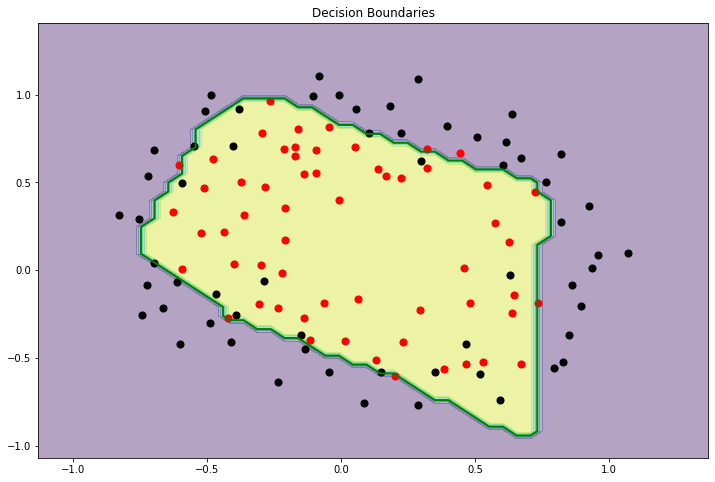

In [165]:
### Decision Boundaries
%matplotlib inline
import matplotlib.pyplot as plt
data = ex2data2

x1_min, x1_max = data[:, 0].min() - 0.3, data[:, 0].max() + 0.3,
x2_min, x2_max = data[:, 1].min() - 0.3, data[:, 1].max() + 0.3,
xx1, xx2 = np.meshgrid(np.linspace(x1_min, x1_max), np.linspace(x2_min, x2_max))

# here "model" is your model's prediction (classification) function
Z = model.predict(np.c_[xx1.ravel(), xx2.ravel()].T, apply_dropout=False) 

negatives = ex2data2[ex2data2[:, -1] == 0]
positives = ex2data2[ex2data2[:, -1] == 1]

# Put the result into a color plot
Z = Z.reshape(xx1.shape)
plt.figure(figsize=(12,8))
plt.contourf(xx1, xx2, Z,alpha=0.4)
#plt.axis('off')
plt.scatter(negatives[:, 0], negatives[:, 1],s=50, color='k')
plt.scatter(positives[:, 0], positives[:, 1],s=50, color='r')
plt.title('Decision Boundaries')

plt.contour(xx1, xx2, Z, [0.5], linewidths=2, colors="g")

# MNIST dataset

In [191]:
from scipy.io import loadmat
data = loadmat('../ex3/data/ex3data1.mat')
data.keys()

dict_keys(['__header__', '__version__', '__globals__', 'X', 'y'])

In [192]:
x = data["X"]
y = data["y"]
y[y==10] = 0

In [193]:
dataset_test, dataset_train = split_data_as(x, y, train=0.9, test=0.1)
X_train = dataset_train[:, :-1].T
Y_train = one_hot_encode(dataset_train[:, -1]).T

X_test = dataset_test[:, :-1].T
Y_test = one_hot_encode(dataset_test[:, -1]).T

Splitting the dataset as train and test...


In [194]:
# X = x.T
# Y = one_hot_encode(y).T

In [195]:
print(X.shape)
print(Y.shape)

(2, 150)
(3, 150)


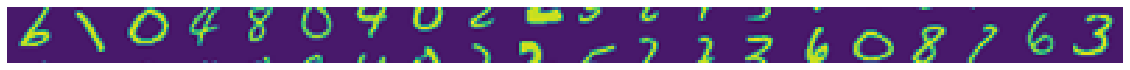

In [196]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20,20))

sample = np.random.choice(data["X"].shape[0], 20)
ax.imshow(data["X"][sample,1:].reshape(-1,20).T)
ax.axis('off');

In [197]:
# http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#4d4e495354

model = NeuralNetwork(
    input_layer=(X_train.shape[0], 'relu'),
    hidden_layer=[(200,'relu'),(100,'relu'),(4,'softmax')],
    output_layer=Y_train.shape[0],
    batch_size=16,
    optimizer={"method": "ADAM", "beta1": 0.9, "beta2": 0.999},
    penalty = "l2",
    keep_prob=1,
    lambd=0.2,
    epoch=100,
    alpha=0.1
)

model.fit(X_train, Y_train)

Initialising weights...
Starting the training...
Initial cost: nan



/home/cagri/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:71: RuntimeWarning: invalid value encountered in true_divide
/home/cagri/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:49: RuntimeWarning: invalid value encountered in less
/home/cagri/anaconda3/envs/my_env/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in less


accuracy: 9.6000000000 - epoch 4    iteration 100 - loss nan
accuracy: 9.6000000000 - epoch 7    iteration 200 - loss nan
accuracy: 9.6000000000 - epoch 10    iteration 300 - loss nan
accuracy: 9.6000000000 - epoch 13    iteration 400 - loss nan
accuracy: 9.6000000000 - epoch 16    iteration 500 - loss nan
accuracy: 9.6000000000 - epoch 19    iteration 600 - loss nan
accuracy: 9.6000000000 - epoch 22    iteration 700 - loss nan
accuracy: 9.6000000000 - epoch 25    iteration 800 - loss nan
accuracy: 9.6000000000 - epoch 29    iteration 900 - loss nan
accuracy: 9.6000000000 - epoch 32    iteration 1000 - loss nan
accuracy: 9.6000000000 - epoch 35    iteration 1100 - loss nan
accuracy: 9.6000000000 - epoch 38    iteration 1200 - loss nan
accuracy: 9.6000000000 - epoch 41    iteration 1300 - loss nan
accuracy: 9.6000000000 - epoch 44    iteration 1400 - loss nan
accuracy: 9.6000000000 - epoch 47    iteration 1500 - loss nan
accuracy: 9.6000000000 - epoch 50    iteration 1600 - loss nan
acc

In [183]:
calculate_model_performance(np.argmax(Y_test, axis=0), model.predict(X_test))

{'specificity': 75.70509648686895,
 'accuracy': 76.08888888887198,
 'prevalence': 10.177777777775516,
 'precision': 27.043090638910073,
 'sensitivity/recall': 79.47598253257756,
 'F1': 40.354767183611884,
 'false_positive_rate': 24.294903513106313}

In [151]:
Y_test.shape

(10, 4500)

In [146]:
# results_dict_all_models, results_average_dict, models = grid_search(
#     x,
#     y,
#     clf=NeuralNetwork,
#     lst_metrics=["F1", "accuracy"],
#     sort_by = "F1",
#     n_folds=10,
#     dict_param_grid={
#         'batch_size': [64, 128, 256],
#         'input_layer': [(x.shape[1], 'relu')],
#         'hidden_layer': [
#             [(50, 'relu'), (25, 'relu'), (10,'softmax')],
#             [(200, 'relu'), (100, 'relu'), (50, 'relu'), (10,'softmax')]
#         ],
#         'optimizer':[
#             {
#                 "method": "ADAM",
#                 "beta1": 0.9,
#                 "beta2": 0.999
#             }
#         ],
#         'output_layer': [10],
#         'alpha': [0.0001, 0.001],
#         'verbose': [False],
#         'epoch': [250]
#     }
# )

# results_average_dict
# print(models["model_1"])

In [147]:
def display_miss_clasifications(model, digits_to_display):
    count = 0
    for index, (act, predicted) in enumerate(zip(np.argmax(Y,axis=0), model.predict(X))):
        if act != predicted:
            fig, ax = plt.subplots(figsize = (2,2))
            ax.set_title("%s: act %s --- predicted %s" %(index, act, predicted))
            ax.imshow(X[:, index].reshape(-1,20).T)
            ax.axis('off');
            count += 1
        if count == digits_to_display:
            break

In [148]:
display_miss_clasifications(model, 50)

ValueError: matmul: Input operand 1 has a mismatch in its core dimension 0, with gufunc signature (n?,k),(k,m?)->(n?,m?) (size 2 is different from 400)